# Alternative Tracing Methods

So far in this module, we've taken a look at the traceable decorator, and how we can use it to set up tracing.

In this lesson, we're going to look at alternative ways in which we can set up tracing, and when you should think about using these different approaches.

## LangChain and LangGraph

If we are using LangChain or LangGraph, all we need to do to set up tracing is to set a few environment variables

In [1]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv()

True

Don't worry too much about our graph implementation here, you can learn more about LangGraph through our LangGraph Academy course!

/Users/manan/PycharmProjects/langsmith-course/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /sentence-transformers/all-MiniLM-l6-v2/resolve/main/modules.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x12964aa50>: Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: 67241b26-34b0-4d6b-b0a7-64ce0d05d941)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-l6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', 

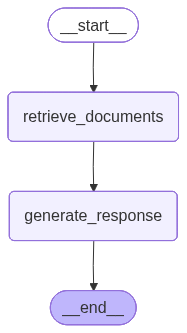

In [2]:
import nest_asyncio
import operator
from langchain.schema import Document
from langchain_core.messages import HumanMessage, AnyMessage, get_buffer_string
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict, Annotated
from utils import get_vector_db_retriever, RAG_PROMPT

nest_asyncio.apply()

retriever = get_vector_db_retriever()
llm = ChatAnthropic(model_name="claude-3-5-haiku-latest", temperature=0)

# Define Graph state
class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]
    documents: List[Document]
    prev_activities: str

# Define Nodes
def retrieve_documents(state: GraphState):
    messages = state.get("messages", [])
    question = state["question"]
    prev_activities = state["prev_activities"]
    documents = retriever.invoke(f"{get_buffer_string(messages)} {question} {prev_activities}")
    return {"documents": documents}

def generate_response(state: GraphState):
    question = state["question"]
    prev_activities = state["prev_activities"]
    messages = state["messages"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, interests=question, prev_activities=prev_activities)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"documents": documents, "messages": [HumanMessage(question), generation]}

# Define Graph
graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

simple_rag_graph = graph_builder.compile()
display(Image(simple_rag_graph.get_graph().draw_mermaid_png()))

We're setting up a simple graph in LangGraph. If you want to learn more about LangGraph, I would highly recommend taking a look at our LangGraph Academy course.

You can also pass in metadata or other fields through an optional config

In [3]:
interests = "I have deep interest in medical imaging"
prev_activities = "Worked on identifying cancer cells using DL and CNNs"
simple_rag_graph.invoke({"question": interests, "prev_activities": prev_activities}, config={"metadata": {"foo": "bar"}})

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'question': 'I have deep interest in medical imaging',
 'messages': [HumanMessage(content='I have deep interest in medical imaging', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Based on the context provided, I recommend reaching out to Rajeev Kumar Singh at Shiv Nadar University, who seems to be an excellent match for potential research collaboration. Here's why:\n\nAlignment of Research Interests:\n1. Machine Learning ✓\n2. Medical Image Computing ✓\n3. Computer Vision ✓\n\nSpecific Evidence of Alignment:\n- Published multiple papers in medical imaging and deep learning\n- Specific works include:\n  - SkiNet: Deep learning framework for skin lesion diagnosis\n  - COVIDScreen: Explainable deep learning for COVID-19 diagnosis\n  - DMENet: Diabetic macular edema diagnosis\n  - CervixNet: Cervical Cancer Diagnosis\n\nAdditional Relevance:\n- Currently an Assistant Professor in Computer Science and Engineering\n- Has extensive experience in applying deep learning to 

##### Let's take a look in LangSmith!

## Tracing Context Manager

In Python, you can use the trace context manager to log traces to LangSmith. This is useful in situations where:

You want to log traces for a specific block of code.
You want control over the inputs, outputs, and other attributes of the trace.
It is not feasible to use a decorator or wrapper.
Any or all of the above.
The context manager integrates seamlessly with the traceable decorator and wrap_openai wrapper, so you can use them together in the same application.

You still need to set your `LANGSMITH_API_KEY` and `LANGSMITH_TRACING`

In [4]:
from langsmith import traceable, trace
from openai import OpenAI
from anthropic import Anthropic
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "anthropic"
MODEL_NAME = "claude-3-5-haiku-latest"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

anthropic_client = Anthropic()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable
def retrieve_documents(question: str):
    documents = retriever.invoke(question)
    return documents

"""
generate_response
- Calls `call_anthropic` to generate a model response after formatting inputs
"""

def generate_response(question: str, documents):
    # NOTE: Our documents came in as a list of objects, but we just want to log a string
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    with trace(
        name="Generate Response",
        run_type="chain",
        inputs={"question": question, "formatted_docs": formatted_docs},
        metadata={"foo": "bar"},
    ) as ls_trace:
        messages = [
            {
                "role": "user",
                "content": f"To the most suitable professor, write a mail for research opportunities. Context: {formatted_docs} \n\n Interests: {question}"
            }
        ]
        response = call_claude(messages, RAG_SYSTEM_PROMPT)
        ls_trace.end(outputs={"output": response})
    return response

"""
call_claude
- Returns the chat completion output from OpenAI
"""
@traceable
def call_claude(
    messages: List[dict], system: str, model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    response = anthropic_client.messages.create(
        model=model,
        system=system,
        messages=messages,
        temperature=temperature,
        max_tokens=1024,
    )
    return response

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.content[0].text


In [5]:
interests = "Interest in Natural Language Processing and Machine Translation"
ai_answer = langsmith_rag(interests)
print(ai_answer)

Here's a draft email for research opportunities:

Subject: Research Collaboration Inquiry in Natural Language Processing and Machine Translation

Dear Professor,

I am writing to express my strong interest in potential research opportunities in Natural Language Processing, particularly focusing on Machine Translation for Indian languages. Given my background in publishing research on machine translation evaluation metrics and my experience presenting at conferences like ICON 2021, I am eager to explore collaborative research possibilities in your department.

Would you be available to discuss potential research projects or assistantships that align with your current work in NLP?

Sincerely,
[Your Name]


## wrap_openai

The wrap_openai/wrapOpenAI methods in Python/TypeScript allow you to wrap your OpenAI client in order to automatically log traces -- no decorator or function wrapping required! The wrapper works seamlessly with the @traceable decorator or traceable function and you can use both in the same application.

You still need to set your `LANGSMITH_API_KEY` and `LANGSMITH_TRACING`

In [12]:
from langsmith.wrappers import wrap_anthropic
import anthropic
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "anthropic"
MODEL_NAME = "claude-3-5-haiku-latest"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

anthropic_client = wrap_anthropic(anthropic.Client())

nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return anthropic_client.messages.create(
        model=MODEL_NAME,
        messages=messages,
        temperature=0,
        max_tokens=1024,
    )

@traceable(run_type="chain")
def langsmith_rag_with_wrap_openai(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.content[0].text


In [13]:
question = "How do I trace with wrap_openai?"
ai_answer = langsmith_rag_with_wrap_openai(question)
print(ai_answer)

I apologize, but I cannot find any information in the provided context about "wrap_openai" or tracing. The context appears to be about a research grant for developing a catalytic membrane for tannery effluent treatment, along with some details about the Shiv Nadar Institution of Eminence and some research publications. 

If you're looking for information about tracing with wrap_openai, you would need to provide more context or specific details about what you're trying to accomplish. Without additional information, I cannot provide a meaningful answer about tracing with wrap_openai.


The wrapped OpenAI client accepts all the same langsmith_extra parameters as @traceable decorated functions

In [15]:
messages = [
    {
        "role": "user",
        "content": "What color is the sky?"
    }
]

anthropic_client.messages.create(
    model=MODEL_NAME,
    messages=messages,
    langsmith_extra={"metadata": {"foo": "bar"}},
    max_tokens=1024,
    temperature=0
)

Message(id='msg_01Qu6zLZZjrwLC2143oovw2N', content=[TextBlock(citations=None, text="The sky is typically blue during clear daytime conditions. The blue color is caused by a phenomenon called Rayleigh scattering, where sunlight is scattered by molecules in the Earth's atmosphere. During sunrise and sunset, the sky can appear orange, red, or pink due to the angle of sunlight. At night, the sky appears dark or black.", type='text')], model='claude-3-5-haiku-20241022', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=Usage(cache_creation=CacheCreation(ephemeral_1h_input_tokens=0, ephemeral_5m_input_tokens=0), cache_creation_input_tokens=0, cache_read_input_tokens=0, input_tokens=13, output_tokens=77, server_tool_use=None, service_tier='standard'))

## [Advanced] RunTree

Another, more explicit way to log traces to LangSmith is via the RunTree API. This API allows you more control over your tracing - you can manually create runs and children runs to assemble your trace. You still need to set your `LANGSMITH_API_KEY`, but `LANGSMITH_TRACING` is not necessary for this method.

![AWTT](../../images/alternative_ways_to_trace_4.png)

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"

In [ ]:
from dotenv import load_dotenv
# I have my env variables defined in a .env file
load_dotenv()

Let's go ahead and set `LANGSMITH_TRACING` to false, as we are using RunTree to manually create runs in this case.

In [16]:
import os
os.environ["LANGSMITH_TRACING"] = "false"

from langsmith import utils
utils.tracing_is_enabled() # This should return false

True

We have rewritten our RAG application, except this time we pass a RunTree argument through our function calls, and create child runs at each layer. This gives our RunTree the same hierarchy that we were automatically able to establish with @traceable

In [24]:
from langsmith import RunTree
from openai import OpenAI
from anthropic import Anthropic
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

anthropic_client = Anthropic()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

def retrieve_documents(parent_run: RunTree, question: str):
    # Create a child run
    child_run = parent_run.create_child(
        name="Retrieve Documents",
        run_type="retriever",
        inputs={"question": question},
    )
    documents = retriever.invoke(question)
    # Post the output of our child run
    child_run.end(outputs={"documents": documents})
    child_run.post()
    return documents

def generate_response(parent_run: RunTree, question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_system_prompt = """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the latest question in the conversation. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    """
    # Create a child run
    child_run = parent_run.create_child(
        name="Generate Response",
        run_type="chain",
        inputs={"question": question, "documents": documents},
    )
    messages = [
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    claude_response = call_anthropic(child_run, messages, rag_system_prompt)
    # Post the output of our child run
    child_run.end(outputs={"claude_response": claude_response})
    child_run.post()
    return claude_response

def call_anthropic(
    parent_run: RunTree, messages: List[dict], rag_system_prompt: str, model: str = "claude-3-5-haiku-latest", temperature: float = 0.0
) -> str:
    # Create a child run
    child_run = parent_run.create_child(
        name="Claude Call",
        run_type="llm",
        inputs={"messages": messages},
    )
    claude_response = anthropic_client.messages.create(
        model=model,
        messages=messages,
        system=rag_system_prompt,
        temperature=temperature,
        max_tokens=1024
    )
    # Post the output of our child run
    child_run.end(outputs={"claude_response": claude_response})
    child_run.post()
    return claude_response

def langsmith_rag(question: str):
    # Create a root RunTree
    root_run_tree = RunTree(
        name="Chat Pipeline",
        run_type="chain",
        inputs={"question": question}
    )

    # Pass our RunTree into the nested function calls
    documents = retrieve_documents(root_run_tree, question)
    response = generate_response(root_run_tree, question, documents)
    output = response.content[0].text

    # Post our final output
    root_run_tree.end(outputs={"generation": output})
    root_run_tree.post()
    return output
    


In [25]:
question = "What are the interests of professors in math department here?"
ai_answer = langsmith_rag(question)
print(ai_answer)

Based on the context provided, the professors in the mathematics department have expertise in:

1. Analysis
2. Algebra and Number Theory

These are the specific areas of mathematical interest mentioned in the work experience and area of expertise sections. The context shows at least one professor has worked in these domains at the School of Natural Sciences, Shiv Nadar University.
